In [1]:
import argparse

import os
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
import cv2

#테스트 이미지 주소

In [2]:
test_img_dir = "/content/drive/MyDrive/cow/QC_cow_segmentation_3_000235.jpg"

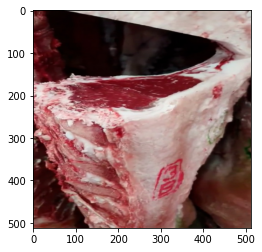

torch.Size([1, 3, 512, 512])


In [3]:
#Resize Image
image = Image.open(test_img_dir)
image = np.array(image)

#Reshape Image to 512 * 512
image = cv2.resize(image, dsize = (512, 512), interpolation = cv2.INTER_AREA)
plt.imshow(image)
plt.show()
#Numpy to Tensor, permute dimension
image = torch.Tensor(image)
image = image.unsqueeze(0)
image = image.permute(0,3,1,2)
print(image.shape)
                     

#UNet 구현

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [5]:
lr = 1e-3
batch_size = 1

device =  torch.device('cpu')


Model_name = "cow_segmentation_unet_less_param"

#학습된 UNet로드, Segmentation 작업 

In [6]:
result_dir = "/content/drive/MyDrive/cow/result_test"
ckpt_dir = "/content/drive/MyDrive/cow/checkpoint_unet_less_param"

## 네트워크 생성하기
net = UNet().to(device)
optim = torch.optim.Adam(net.parameters(), lr= lr)

fn_class = lambda x: 1.0 * (x > 0.5)
##네트워크 호출
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch, 0, None, np.inf

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])
    es_counter = dict_model['es_counter']
    best_score = dict_model['best_score']
    v_loss_min = dict_model['v_loss_min']

    return net, optim, epoch, es_counter, best_score, v_loss_min 

#네트워크 초기값
st_epoch = 0
st_es_counter = 0
st_best_score = None
st_val_min_loss = np.inf
#학습된 net 호출
net, optim, st_epoch, st_es_counter, st_best_score, st_val_min_loss = load(ckpt_dir = ckpt_dir, net = net, optim = optim)

image = image.to(device)
output = net(image)
output = fn_class(output)
output = output.detach()

In [7]:
#Squeeze output, permute dimension
output = output.squeeze(0)
output = output.permute(1,2,0)
#Tensor to Numpy
output = output.numpy()
#Change to 3 dim image
output = np.concatenate((output,)*3 ,axis = -1)

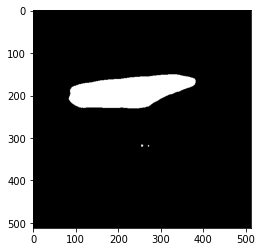

In [8]:
plt.imshow(output)
plt.show()

#원본이미지와 겹쳐 중요 부위만 추출

In [9]:
#Squeeze image, permute dimension
image = image.squeeze(0)
image = image.permute(1,2,0)
#Tensor to Numpy
image = image.numpy()
#0-255 to 0-1
image = image/255.0
#Change to 3 dim image
print(image.shape)

(512, 512, 3)


In [10]:
#make new image
output = np.where(output!=0,1,output)
newimg = output * image


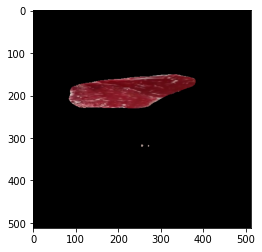

In [11]:
plt.imshow(newimg)
plt.show()

#ResNet 구현

In [12]:
import torch.nn as nn
class ResidualBlock(nn.Module):
    def __init__(self,indim,middim,outdim,stride=1):
        super(ResidualBlock, self).__init__()
        self.Bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=indim, out_channels=middim, kernel_size=1,stride=1),
            nn.BatchNorm2d(num_features=middim),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=middim, out_channels=middim, kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(num_features=middim),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=middim, out_channels=outdim, kernel_size=1),
            nn.BatchNorm2d(num_features=outdim),
            nn.ReLU(inplace=True)
        )
        self.iden = nn.Sequential(
            nn.Conv2d(in_channels=indim, out_channels=outdim,kernel_size=1, stride=stride),
            nn.BatchNorm2d(outdim)
        )
    def forward(self,x):
        output = self.iden(x) + self.Bottleneck(x)
        return output
class Resnet(nn.Module):

    def __init__(self):
        super(Resnet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(3,2,1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64,64,256),
            ResidualBlock(256,64,256,stride=2),
            ResidualBlock(256,64,256)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(256,128,512,stride=2),
            ResidualBlock(512,128,512),
            ResidualBlock(512,128,512),
            ResidualBlock(512,128,512)
        )

        self.layer4 = nn.Sequential(
            ResidualBlock(512,256,1024,stride=2),
            ResidualBlock(1024,256,1024),
            ResidualBlock(1024,256,1024,stride=2),
            ResidualBlock(1024,256,1024),
            ResidualBlock(1024,256,1024,stride=2),
            ResidualBlock(1024,256,1024)
        )

        self.layer5 = nn.Sequential(
            ResidualBlock(1024,512,2048,stride=2),
            ResidualBlock(2048,1024,2048),
            ResidualBlock(2048,1024,2048)
        )

        self.fc = nn.Linear(2048, 5)
        self.avgpool = nn.AvgPool2d((2,2))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

#학습된 ResNet로드, Predicted label 계산

In [13]:
PATH = "/content/drive/MyDrive/cow/res_model.pt"
table = ['1','1+','1++','2','3']
transform = transforms.Compose([transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
class_model = Resnet()
class_model.load_state_dict(torch.load(PATH))
class_model.to(device)
class_model.eval()

newimg = torch.Tensor(newimg)
newimg = newimg.permute(2,0,1)
newimg = transform(newimg)
newimg = newimg.to(device)

newimg = newimg.unsqueeze(0)
predicted_outputs = class_model(newimg)

print(predicted_outputs)
print(table[int(torch.max(predicted_outputs,dim=1)[1])])




tensor([[-1.2637, -2.0775, -0.3722,  1.3307,  7.1727]],
       grad_fn=<AddmmBackward0>)
3
